In [166]:
import numpy as np
import stat as stats
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

Import the earthquake data

In [167]:
loc = "earthquake files-20221127\EarthquakeExerciseData.txt"
data_earthquake = np.loadtxt(loc)

This is the modified Julia code that is provided. Changed it to get everything into more of a numpy format.
ie. world is Sx2 array with all world coordinates, 
sensors is a Nx2 array with all sensor coordinates


This function creates the world coordinates and the sensor locations

In [168]:
def earthquake_exercise_setup(station_num=30, spiral_points_num=2000, angular_spiral_rate=25):
    # explosion detector (using spiral coordinate system)
    # define the coordinate system:
    S = spiral_points_num # number of points on the spiral
    rate = angular_spiral_rate # angular rate of spiral
    
    # array to hold world coordinates (x, y)
    world = np.zeros((S, 2))
    
    # iteratively work around the spiral filling in cartesian location values in x and y
    for s in range(S):
        r = s / S        
        theta = rate * 2 * np.pi * r
        world[s, 0] = r * np.cos(theta)
        world[s, 1] = r * np.sin(theta)

    # define the locations of the detection stations on the surface
    # Also define what value on each sensor would be generated by an explostion at internal location s
    N = station_num # number of stations
    
    # array to hold sensor locations
    sensors = np.zeros((N, 2))
    
    for sensor in range(N):
        # initialise x, y values for each sensor
        theta_sensor = 2 * np.pi * sensor / N
        sensors[sensor, 0] = np.cos(theta_sensor)
        sensors[sensor, 1] = np.sin(theta_sensor)
    
    return world, sensors

In [169]:
def calculate_log_likelihood(world, sensors, sensor_data, sensor_sd, is_two_explosion=False):
    """calculate likelihood at each point in world coordinates

    Args:
        world : Sx2 array, each row being (x,y) coords in world space
        sensors : Nx2 array, each row being (x,y) coords of sensors on world surface
        sensor_data : N array, N[i] being visble signal at sensors[i] location
        sensor_sd : standard deviation of sensor recieved signal
    
    Return:
        log_like : N array of log likelihoods at each world point
    """
    S = world.shape[0]
    N = sensors.shape[0]
    large = 1e10
    
    # distance array to hold distance between sensor i and world point j at index [j, i]
    dist = np.zeros((S, N))
    
    for sensor in range(N):
        dist[:, sensor] = np.linalg.norm(world - sensors[sensor], axis=1)
    
    # array of theoretical signal from a single explosion. At [j,i] is signal at sensor[i] from explosion point world[j]
    world_signal = 1 / (dist**2 + 0.1)
    
    # array to store likelihood of receiving signal v at sensor[i] from explosion at world[j] - stored at [j,i]
    like_at_each_s1 = np.zeros(S)
    log_like_at_each_s1 = np.zeros(S)
    
    # calculate p(s1|v)
    for s1 in range(S):
        sd_factor = -1 / (2 * sensor_sd**2)
        if is_two_explosion:
            # marginalise over s2
            for s2 in range(S):
                like_at_each_s1[s1] += np.exp(sd_factor * ((sensor_data - world_signal[s1, :] - world_signal[s2, :])**2).sum())
        else:
            log_like_at_each_s1[s1] = sd_factor * ((sensor_data - world_signal[s1, :])**2).sum()
    
    if is_two_explosion:
        log_like_at_each_s1 = np.log(like_at_each_s1)
    
    # array is S long
    return log_like_at_each_s1

In [192]:
# Function to plot the world, sensors, visible signal, Highest likelihood location and likelihood heat map

def show_earth_likelihood(sensor_locations, world, like, data=None, axes=None, visual_scale=0.8, is_two_explosions=False, title='Title'):
    radial_scale = 0.05
    
    if axes is None:
        figure, axes = plt.subplots()
    axes.set_title(title)
    
    draw_circle = plt.Circle((0, 0), 1,fill=False)

    axes.set_aspect(1)
    axes.add_artist(draw_circle)
    
    # Only showing the top 20% of results that are above 0 on the colour map (there are plenty of results with -inf or even smaller due to tiny probs)
    colormap = plt.cm.Greys #or any other colormap
    
    # take top visual_scale % of likelihoods that aren't -inf
    is_not_inf_index = np.logical_not(np.isinf(like))
    sorted_like = np.sort(like[is_not_inf_index])
    N = int(sorted_like.size) - 1
    visual_min = sorted_like[N - int(N * visual_scale)]
    
    normalize = colors.Normalize(vmin=visual_min, vmax=like.max())
    axes.scatter(world[:,0], world[:,1], c=like, s=5, cmap=colormap, norm=normalize, marker='*')
    
    if data is not None:
        # generate vectors pointing out from centre representing visible signal
        radial_signal = sensor_locations * radial_scale * data.reshape((-1, 1)) + sensor_locations
        for sensor in np.arange(sensor_locations.shape[0]):
            x = [sensor_locations[sensor, 0], radial_signal[sensor, 0]]
            y = [sensor_locations[sensor, 1], radial_signal[sensor, 1]]
            axes.plot(x, y, c='red')
    
    
    # plot the sensors onto the earth
    axes.scatter(sensor_locations[:,0], sensor_locations[:,1], c='black', s=15)
    
    # plot the max likelihood point
    max_like_index = like.argmax()
    axes.scatter(world[max_like_index,0], world[max_like_index,1], c='red', marker='x', s=70, label='Global Max likelihood')
    
    if is_two_explosions:
        world_right_index = world[:,0] > -0.3
        like_world_right = like[world_right_index]
        world_right = world[world_right_index]
        max_2_like_index = like_world_right.argmax()
        axes.scatter(world_right[max_2_like_index,0], world_right[max_2_like_index,1], c='red', marker='^', s=70, label='Local Max Likelihood')
    
    axes.legend()
    axes.axis('off')

Setup world and sensors coordinates and calculate likelihood

In [173]:
world, sensors = earthquake_exercise_setup()
log_like_2_explosions = calculate_log_likelihood(world, sensors, data_earthquake, sensor_sd=0.2, is_two_explosion=True)
log_like_1_explosions = calculate_log_likelihood(world, sensors, data_earthquake, sensor_sd=0.2, is_two_explosion=False)

C:\Users\fl_cl\AppData\Local\Temp\ipykernel_1888\775783429.py:51: RuntimeWarning: divide by zero encountered in log
  log_like_at_each_s1 = np.log(like_at_each_s1)


show results

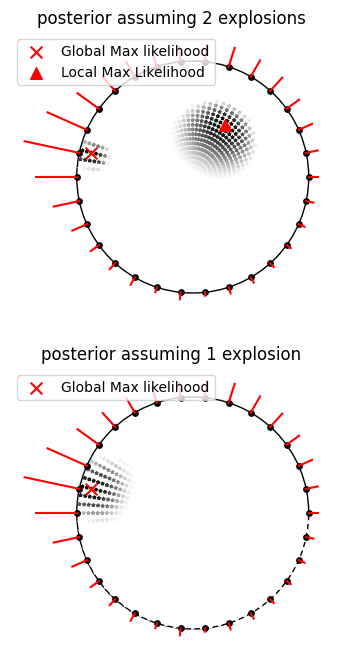

In [193]:
fig, axs = plt.subplots(2, figsize=(8,8))

show_earth_likelihood(sensors, world, log_like_2_explosions, data_earthquake, axes=axs[0], visual_scale=0.3, is_two_explosions=True, title='posterior assuming 2 explosions')
show_earth_likelihood(sensors, world, log_like_1_explosions, data_earthquake, axes=axs[1], visual_scale=0.05, is_two_explosions=False, title='posterior assuming 1 explosion')